# Torch implementation of High Dimentional PDE solver using neural networks

In this notebook I implemented the paper "Solving High-Dimensional Partial Differential Equations Using
Deep Learning" by Jiequn Han, Arnulf Jentzen and Weinan E. https://arxiv.org/pdf/1707.02568.

I used torch.nn class extention (the papers authors implemented it using TensorFlow), implenting different version of the training block as well as forward and backpropagation for the recursive computation of $u$. I then proceed to reproduce the results of the 3 examples of the paper.

### importing libraries

In [2]:

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


### Generating X and W

In [3]:
#Generates a brownian motion
def generate_delta_brownian(B, N, d, T, generator=None, device=None, dtype=None):
    g = generator if generator is not None else torch.Generator(device=device)
    dW = torch.randn((B, N, d), generator=g, device=device, dtype=dtype) * math.sqrt(T/N)
    return dW


def get_time_scale(N,T):
    return torch.linspace(0,T,N+1)

# compute X size: b batch_size, N step , d dimension
def simulate_X(xi, delta_W, mu, sigma, T):
    B,N,d=delta_W.shape
    t=get_time_scale(N,T).to(delta_W.device, delta_W.dtype)
    X=torch.empty(B,N+1,d,device=delta_W.device, dtype=delta_W.dtype)
    if torch.is_tensor(xi):
        if xi.dim() == 0: X[:, 0, :].fill_(xi.item())
        elif xi.dim() == 1: X[:, 0, :] = xi
        else: X[:, 0, :] = xi
    else:
        X[:, 0, :].fill_(xi)
    for n in range(N):
        X[:,n+1,:]=X[:,n,:] + mu(t[n],X[:,n,:]) * (T/N) + torch.einsum("bij,bj->bi",sigma(t[n],X[:,n,:]),delta_W[:,n,:])
    return X


### Defining model archituchture

In [4]:
# this is a class storing various parameters and functions of our model
class parameters():
    def __init__(self, f, sigma, mu, delta_W, X, time_scale, df_du, df_dgrad):
        self.B=delta_W.shape[0] # batch size
        self.N=delta_W.shape[1] # number of paths
        self.d=delta_W.shape[2] # dimension
        self.f=f                # (t,X,u,du) : ( 1 x d x 1 x d ) -> 1     non-linear function  CAREFULL: Batch_Size broadcastable output: (Bx...)x1
        self.sigma=sigma        # (t,X) : (1 x d) -> (d x d)       matrix function  CAREFULL: Batch_Size/time broadcast output (Bx...)xdxd
        self.mu=mu              # (t,X) : (1 x d) -> (d)            vector function CAREFULL: Batch_Size/time broadcast output (Bx...)xd
        self.delta_W=delta_W    # (B x N x d)
        self.X=X                # size: B batch_size, N+1 step , d dimension
        self.df_du=df_du        # (t,X,u,du) : ( 1 x d x 1 x d ) -> ... x 1 gradient of f w.r.t. 2nd to last argument
        self.df_dgrad=df_dgrad  # (t,X,u,du) : ( 1 x d x 1 x d ) -> ... x d gradient of f w.r.t. last argument
        self.time_scale=time_scale # time steps from t_0 to t_N, shape : N+1

In [5]:
#naive loop impplementation of the MLP part
class block(nn.Module):
    def __init__(self,net_dims): #dims=(d,d+10,d+10,d)
        super().__init__()
        layers=[]
        for i in range(len(net_dims)-2):
            layers+=[nn.Linear(net_dims[i],net_dims[i+1]),nn.ReLU()]
        layers.append(nn.Linear(net_dims[-2],net_dims[-1]))
        self.net=nn.Sequential(*layers)

    def forward(self,x):
        return self.net(x)


class network(nn.Module):
    def __init__(self,net_dims,N):
        super().__init__()
        self.net=nn.ModuleList([
            block(net_dims) for _ in range(N-1)
        ])
        self.N=N

    def forward(self,X):
        # inefficient on a GPU, should be computed in parallel.
        B,_,d=X.shape

        h_H=torch.zeros(B,self.N-1,d,device=X.device, dtype=X.dtype)
        for i,blk in enumerate(self.net):
            h_H[:,i,:]=blk(X[:,i+1,:]) #dim B x d
        return h_H # dim B x N-1 x d

In [66]:
#better (parallel) implementation
class TimeMLP(nn.Module):
    def __init__(self, d, hidden=64, t_embed=16,use_tanh=False,z_scale=1.0):
        super().__init__()
        self.temb = nn.Sequential(nn.Linear(1, t_embed), nn.ReLU(),
                                  nn.Linear(t_embed, t_embed), nn.ReLU())
        self.net  = nn.Sequential(nn.Linear(d + t_embed, hidden), nn.ReLU(),
                                  #nn.Linear(hidden, hidden), nn.ReLU(),
                                  nn.Linear(hidden, d))
        self.use_tanh=use_tanh # optional final tanh layer to clip grad_u (output of this module)
        self.z_scale=z_scale

    def forward(self, t_scalar, x):
        grad_u=self.net(torch.cat([x, self.temb(t_scalar)], dim=-1))
        if self.use_tanh:
            # Bound to [-1, 1], then normalize by sqrt(d)
            grad_u = torch.tanh(grad_u) / math.sqrt(grad_u.shape[-1] + 1e-8)
        return self.z_scale * grad_u



class Time_network(nn.Module):
    def __init__(self, d, N,hidden, use_tanh=False, z_scale=1.0):
        super().__init__()
        self.N = N

        self.core = TimeMLP(d,hidden=hidden,use_tanh=use_tanh,z_scale=z_scale)
    def forward(self, X, t):
        B, _, d = X.shape
        X_steps = X[:, 1:self.N, :].reshape(-1, d)
        t_steps = t[1:self.N].repeat_interleave(B).unsqueeze(-1).to(X.device, X.dtype)
        h = self.core(t_steps, X_steps).reshape(B, self.N-1, d)
        return h

In [7]:
# torch autograd for computation of u given h[:,H-1] , h shape: N-1 x H ; delta_W shape: d x N-1;

class recursive_part_fn(torch.autograd.Function):
    @staticmethod
    def forward(ctx, h_H, theta_u_0, theta_grad_u_0, params):
        # h_H shape : B x N-1 x d
        t=params.time_scale.to(params.X.device, params.X.dtype)
        dt=t[1]-t[0]
        # init z = sigma^T h_H
        z = torch.empty(params.B,params.N,params.d, device=params.X.device, dtype=params.X.dtype) # z=sigma.T @ grad_u
        z[:,0,:] = torch.einsum("bij,i->bj",params.sigma(t[0],params.X[:,0,:]),theta_grad_u_0) # B x d x d @ d -> B x d
        z[:,1:,:]=torch.einsum('bnij,bni->bnj', params.sigma(t[1:params.N].unsqueeze(-1),params.X[:,1:params.N,:]), h_H)

        # init u
        u = torch.zeros(params.B,params.N+1,1,device=params.X.device, dtype=params.X.dtype)
        u[:,0,:]=theta_u_0 # shape theta_u_0 : (1,), extended to (Bx1)


        for n in range(params.N):
            stoch = (z[:, n, :] * params.delta_W[:, n, :]).sum(dim=-1, keepdim=True) #B x 1
            u[:,n+1,:] = u[:,n,:] - params.f(t[n],params.X[:,n,:],u[:,n,:],z[:,n,:])* dt + stoch

        ctx.save_for_backward(t,params.X,u,h_H,params.delta_W, theta_u_0, theta_grad_u_0)
        ctx.df_dgrad=params.df_dgrad
        ctx.df_du=params.df_du
        ctx.sigma=params.sigma
        ctx.dims=(params.B, params.N, params.d)
        ctx.dt= dt

        return u[:,-1,:]

    @staticmethod
    def backward(ctx,grad_output):
        B,N,d=ctx.dims
        t,X,u,h_H,delta_W, theta_u_0, theta_grad_u_0=ctx.saved_tensors
        dt=t[1]-t[0]
        # we recompute z for better memory efficiency
        z = torch.empty(B,N,d, device=X.device, dtype=X.dtype) # z=sigma.T @ grad_u
        z[:,0,:] = torch.einsum("bij,i->bj",ctx.sigma(t[0],X[:,0,:]),theta_grad_u_0) # B x d x d @ d -> B x d
        z[:,1:,:]=torch.einsum('bnij,bni->bnj', ctx.sigma(t[1:N].unsqueeze(-1),X[:,1:N,:]), h_H)

        dL_dz=torch.empty_like(z)


        g=grad_output.clone()
        for n in reversed(range(N)):

            dL_dz[:,n,:]=(-ctx.df_dgrad(t[n],X[:,n,:], u[:,n,:], z[:,n,:])*dt + delta_W[:,n,:]) * g

            g=( 1.0-ctx.df_du(t[n], X[:,n,:], u[:,n,:], z[:,n,:])*dt ) * g


        dL_dgrad_u=torch.einsum('bnij,bni->bnj', ctx.sigma(t[:N].unsqueeze(-1),X[:,:N,:]), dL_dz)# shape B x N x d
        #dL_dh_0 is simply the gradient w.r.t. grad_u_0

        return dL_dgrad_u[:,1:,:], g.sum(dim=0), dL_dgrad_u[:,0,:].sum(dim=0), None





class recursive_part(nn.Module):
    def __init__(self, params, init_theta_u_0=None, init_theta_grad_u_0=None, trace=False ):
        super().__init__()
        self.params=params
        self.trace  = trace
        self.last_u = None   # [B, N+1, 1]
        self.last_z = None   # [B, N, d]

        with torch.no_grad():
            if init_theta_u_0==None:
                self.theta_u_0=nn.Parameter(torch.tensor(50.))
            else:
                self.theta_u_0=nn.Parameter(torch.as_tensor(init_theta_u_0))

            if init_theta_grad_u_0==None:
                self.theta_grad_u_0=nn.Parameter(torch.ones(params.d) / params.d)
            else:
                self.theta_grad_u_0=nn.Parameter(init_theta_grad_u_0)



    def forward(self,h_H):
        u_N=recursive_part_fn.apply(h_H, self.theta_u_0, self.theta_grad_u_0, self.params)

        if self.trace:
            # Rebuild u and z deterministically (same ops as in forward) for logging/regularization
            B, N, d = self.params.B, self.params.N, self.params.d
            t  = self.params.time_scale.to(self.params.X.device, self.params.X.dtype)
            dt = t[1] - t[0]
            z  = torch.empty(B, N, d, device=self.params.X.device, dtype=self.params.X.dtype)
            sig0 = self.params.sigma(t[0], self.params.X[:, 0, :])
            z[:, 0, :] = torch.einsum('bji,i->bj', sig0, self.theta_grad_u_0)
            sig_all = self.params.sigma(t[1:N], self.params.X[:, 1:N, :])
            z[:, 1:, :] = torch.einsum('bnji,bnj->bni', sig_all, h_H)

            u = torch.empty(B, N+1, 1, device=self.params.X.device, dtype=self.params.X.dtype)
            u[:, 0, 0] = self.theta_u_0[0] if self.theta_u_0.ndim > 0 else self.theta_u_0
            for n in range(N):
                stoch = (z[:, n, :] * self.params.delta_W[:, n, :]).sum(dim=-1, keepdim=True)
                drift = self.params.f(t[n], self.params.X[:, n, :], u[:, n, :], z[:, n, :]) * dt
                u[:, n+1, :] = u[:, n, :] - drift + stoch

            self.last_u = u.detach()
            self.last_z = z.detach()

        return u_N



In [62]:
# Model: time-shared MLP over steps
class Time_solver(nn.Module):
    def __init__(self, params, hidden=None, init_theta_u0=None, init_theta_grad_u_0=None,use_tanh=False,z_scale=1.0):
        super().__init__()
        self.params = params
        hidden=hidden if hidden is not None else 64
        self.net = Time_network(params.d, params.N, hidden=hidden, use_tanh=use_tanh, z_scale=z_scale)
        self.rec = recursive_part(params, trace=True, init_theta_u_0=init_theta_u0, init_theta_grad_u_0=init_theta_grad_u_0)  # trace to expose last_u/last_z
    def forward(self, X, t):
        h = self.net(X, t)         # [B, N-1, d]
        uT = self.rec(h)           # [B, 1]; also sets rec.last_u, rec.last_z
        return uT

In [9]:
class solver(nn.Module):
    def __init__(self,params, net_dims, init_theta_u_0=None, init_theta_grad_u_0=None):
        super().__init__()
        self.net=network(net_dims,params.N)
        self.rec=recursive_part(params, init_theta_u_0, init_theta_grad_u_0)
    def forward(self,x):
        # n x N-1 linear layers of h
        # recursive part
        h=self.network(X)
        u=self.recursive_part(h)
        return u



### Useful functions/classes for training

In [10]:
# For early stopping during training time
class EarlyStopper:
    def __init__(self, patience_checks=10, min_delta=1e-4):
        self.patience_checks = patience_checks
        self.min_delta = min_delta
        self.best = float("inf")
        self.num_bad = 0

    def step(self, value):
        """Return True to stop early."""
        if value + self.min_delta < self.best:
            self.best = value
            self.num_bad = 0
            return False
        else:
            self.num_bad += 1
            return self.num_bad >= self.patience_checks

def init_history():
    return dict(
        epoch=[],
        train_loss=[],
        eval_rmse=[],
        corr=[],
        u0=[],
        z_rms=[],
    )

In [24]:

def plot_history(history, start_loss=0, start_rmse=0, start_u0=0, title="Training history"):
    ep   = np.array(history["epoch"])
    tr   = np.array(history["train_loss"], dtype=float)
    rmse = np.array(history["eval_rmse"], dtype=float)
    u0   = np.array(history["u0"], dtype=float)
    zr   = np.array(history["z_rms"], dtype=float)

    fig, axs = plt.subplots(1, 3, figsize=(13, 4))

    # --- Train loss ---
    mask1 = ep >= start_loss
    axs[0].plot(ep[mask1], tr[mask1], label="train loss")
    axs[0].set_title("Train loss")
    axs[0].set_xlabel("epoch"); axs[0].grid(True); axs[0].legend()

    # --- Eval RMSE ---
    mask2 = ep >= start_rmse
    axs[1].plot(ep[mask2], rmse[mask2], label="eval RMSE")
    axs[1].set_title("Eval RMSE")
    axs[1].set_xlabel("epoch"); axs[1].grid(True); axs[1].legend()

    # --- u0 and z_rms (dual axis) ---
    mask3 = ep >= start_u0
    ax3 = axs[2]
    l1 = ax3.plot(ep[mask3], u0[mask3], label="u0", color="C0")
    ax3.set_xlabel("epoch"); ax3.set_ylabel("u0", color="C0")
    ax3.tick_params(axis='y', labelcolor="C0")
    ax3.grid(True, linestyle="--", alpha=0.5)

    ax3b = ax3.twinx()
    l2 = ax3b.plot(ep[mask3], zr[mask3], label="z_rms", color="C1")
    ax3b.set_ylabel("z_rms", color="C1"); ax3b.tick_params(axis='y', labelcolor="C1")

    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

### Black-Scholes Framework

In [13]:

class Black_Scholes:
    def __init__(self, delta=2/3, R=0.02, v_h=50 , v_l=70, gamma_h=0.2, gamma_l=0.02, T=1, mu_bar=0.02, sigma_bar=0.2, driver_mode="pricing"):
        self.delta=delta
        self.v_h=v_h
        self.v_l=v_l
        self.gamma_l=gamma_l
        self.gamma_h=gamma_h
        self.R=R
        self.mu_bar=mu_bar
        self.T=T
        self.sigma_bar=sigma_bar
        self.delta_W=None
        self.X=None
        self.driver_mode=driver_mode

    def Q(self,y):
        low=y<self.v_h
        high=y>self.v_l
        mid  = (~low) & (~high)
        out = torch.empty_like(y)
        out[low]=self.gamma_h
        out[high]=self.gamma_l
        out[mid]=(self.gamma_h-self.gamma_l)/(self.v_h-self.v_l)*(y[mid] - self.v_h) + self.gamma_h
        return out

    def dQ_du(self, u):
        mid=(u>self.v_h) & (u<=self.v_l)
        out=torch.zeros_like(u)
        out[mid]=(self.gamma_h-self.gamma_l)/(self.v_h-self.v_l)
        return out
    def f(self,t,x,u,sig_grad_u):
        return -(1-self.delta)*self.Q(u)*u - self.R*u
    def df_du(self,t,x,u,sig_grad_u):
        return -(1-self.delta)*(self.Q(u) + u * self.dQ_du(u)) - self.R
    def df_dgrad(self, t, x, u, sig_grad_u):
        return torch.zeros_like(sig_grad_u)

    def sigma_func(self,t,x):
        d=x.shape[-1]
        I = torch.eye(d, device=x.device, dtype=x.dtype)
        return self.sigma_bar * I * x.unsqueeze(-1) #output x.shape[:-1] x d x d

    def mu_func(self,t,x):
        return self.mu_bar*x

    ################

    def f_price(self, t, x, u, z):     return -self.R * u
    def df_du_price(self, t, x, u, z): return -self.R * torch.ones_like(u)
    def df_dgrad_price(self, t, x, u, z): return torch.zeros_like(z)
    def mu_price(self, t, x): return self.R * x

    def select_driver(self):
        if self.driver_mode == "pricing":
            self.f, self.df_du, self.df_dgrad = self.f_price, self.df_du_price, self.df_dgrad_price
            self.mu_func = self.mu_price
        else:
            # nonlinear driver
            self.f, self.df_du, self.df_dgrad = self.f, self.df_du, self.df_dgrad
            self.mu_func = self.mu_func

    @staticmethod
    def g(x):
        return x.min(dim=-1).values

In [14]:
import math, torch, torch.nn as nn

@torch.no_grad()
def make_eval_set(bs, B_eval, N, d, device, dtype, seed=999):
    gen = torch.Generator(device=device).manual_seed(seed)
    dW = torch.randn((B_eval, N, d), generator=gen, device=device, dtype=dtype) * math.sqrt(bs.T / N)
    xi = torch.full((B_eval, d), 100.0, device=device, dtype=dtype)
    X  = simulate_X(xi, dW, bs.mu_func, bs.sigma_func, bs.T)
    return dW, X

def make_train_paths(bs, B, N, d, device, dtype, seed=None, antithetic=False):
    gen = torch.Generator(device=device)
    if seed is not None:
        gen.manual_seed(seed)
    dW = torch.randn((B, N, d), generator=gen, device=device, dtype=dtype) * math.sqrt(bs.T / N)
    if antithetic:
        dW = torch.cat([dW, -dW], dim=0)  # doubles batch
    xi = torch.full((dW.size(0), d), 100.0, device=device, dtype=dtype)
    X  = simulate_X(xi, dW, bs.mu_func, bs.sigma_func, bs.T)
    return dW, X

# we use a cosine learning rate, adam optimizer with default parameters as well as early stopping
def train_deep_bsde(
    d=10, N=40, B=4096, epochs=600, driver_mode="pricing",
    lr=3e-3, z_reg=1e-6, antithetic=False, hidden=64, device=None, dtype=torch.float32, seed=0, resample=True,
    early_stop=True, check_every=5, patience_checks=10, min_delta=1e-4
):
    device = device or (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    torch.manual_seed(seed)


    bs = Black_Scholes(T=1.0, mu_bar=0.05, sigma_bar=0.2, R=0.02, driver_mode=driver_mode)
    bs.select_driver()

    # Fixed eval set
    B_eval = B
    dW_eval, X_eval = make_eval_set(bs, B_eval, N, d, device, dtype)

    # Initial train set
    dW, X = make_train_paths(bs, B, N, d, device, dtype, seed=seed, antithetic=antithetic)
    t = get_time_scale(N, bs.T).to(device=device, dtype=dtype)

    # Params container
    params = parameters(bs.f, bs.sigma_func, bs.mu_func, dW, X, t, bs.df_du, bs.df_dgrad)

    # Model: time-shared MLP over steps

    model = Time_solver(params,hidden=hidden).to(device)
    model.rec.trace = False
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs, eta_min=1e-5)
    mse = nn.MSELoss()

    stopper = EarlyStopper(patience_checks=patience_checks, min_delta=min_delta) if early_stop else None
    history = init_history()

    for ep in range(1, epochs+1):
        model.train()
        model
        opt.zero_grad(set_to_none=True)

        # Resample training paths each epoch
        if resample:
            dW, X = make_train_paths(bs, B, N, d, device, dtype, seed=None, antithetic=antithetic)
        # update params tensors in-place (so references inside modules remain valid)
        with torch.no_grad():
            model.rec.params.delta_W.set_(dW)
            model.rec.params.X.set_(X)
            model.rec.params.B, model.rec.params.N, model.rec.params.d = dW.shape

        # Forward and loss
        uT = model(X, t)                                      # [B,1]
        gT = bs.g(X[:, -1, :]).unsqueeze(-1)                  # [B,1]


        loss_term = mse(uT, gT)

        # z-regularization (very small)
        z_pen = 0.0
        if model.rec.last_z is not None and z_reg > 0:
            z_pen = (model.rec.last_z.square().mean()) * (bs.T / N)  # average over time
        loss = loss_term + z_reg * z_pen

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        opt.step(); sched.step()

        do_eval = (ep % check_every == 0) or (ep == 1)
        do_print = (ep % 20 == 0) or (ep == 1)

        if do_eval:
            model.eval()
            with torch.no_grad():
                model.rec.trace = True
                # Eval uses fixed paths for stability
                model.rec.params.delta_W.set_(dW_eval)
                model.rec.params.X.set_(X_eval)
                model.rec.params.B, model.rec.params.N, model.rec.params.d = dW_eval.shape

                uT_eval = model(X_eval, t)
                gT_eval = bs.g(X_eval[:, -1, :]).unsqueeze(-1)

                mse_eval = mse(uT_eval, gT_eval).item()
                rmse_eval = math.sqrt(mse_eval)
                corr = torch.corrcoef(torch.stack([uT_eval.squeeze(), gT_eval.squeeze()], 0))[0,1].item()
                theta_u0 = float(model.rec.theta_u_0.detach().cpu())

                zn = float(model.rec.last_z.square().mean().sqrt().cpu()) if model.rec.last_z is not None else float('nan')

                 # Log
                history["epoch"].append(ep)
                history["train_loss"].append(float(loss.item()))
                history["eval_rmse"].append(float(rmse_eval))
                history["corr"].append(float(corr))
                history["u0"].append(theta_u0)
                history["z_rms"].append(float(zn))

                if do_print:
                    print(f"[{ep:03d}] train_loss={loss.item():.6f}  eval_rmse={rmse_eval:.4f}  corr={corr:.4f}  "
                          f"u0={theta_u0:.4f}  z_rms={zn:.4f}")


                if early_stop and ep >= check_every:
                    if stopper.step(rmse_eval):
                        if do_print:
                            print(f"Early stopping at epoch {ep} (no improvement for {patience_checks} checks).")
                        break
                model.rec.trace = False
    return model, history


In [35]:
model, his=train_deep_bsde(lr=5*1e-1,B=256,d=100,hidden=64,epochs=400,N=40)

[001] train_loss=13048293.000000  eval_rmse=3423363.7115  corr=-0.1936  u0=50.4997  z_rms=342746.1562
[020] train_loss=3169.865723  eval_rmse=40.4598  corr=-0.0163  u0=54.1505  z_rms=4.0049
[040] train_loss=219.625824  eval_rmse=15.6745  corr=-0.0266  u0=57.7625  z_rms=1.4183
[060] train_loss=49.125732  eval_rmse=12.4713  corr=0.0267  u0=59.3284  z_rms=1.0864
[080] train_loss=50.242599  eval_rmse=12.8007  corr=0.0864  u0=59.3058  z_rms=1.1588
[100] train_loss=27.227341  eval_rmse=11.6841  corr=0.0778  u0=59.1620  z_rms=1.0772
[120] train_loss=17.679150  eval_rmse=11.6774  corr=0.0319  u0=59.1969  z_rms=1.0471
[140] train_loss=24.874718  eval_rmse=11.4966  corr=0.0103  u0=59.2168  z_rms=1.0129
[160] train_loss=14.419148  eval_rmse=11.4767  corr=0.0200  u0=59.2111  z_rms=1.0229
[180] train_loss=51.402992  eval_rmse=12.8598  corr=0.1043  u0=59.1615  z_rms=1.2019
[200] train_loss=10.312764  eval_rmse=12.0472  corr=0.0111  u0=59.1940  z_rms=1.0841
[220] train_loss=24.560944  eval_rmse=11.81

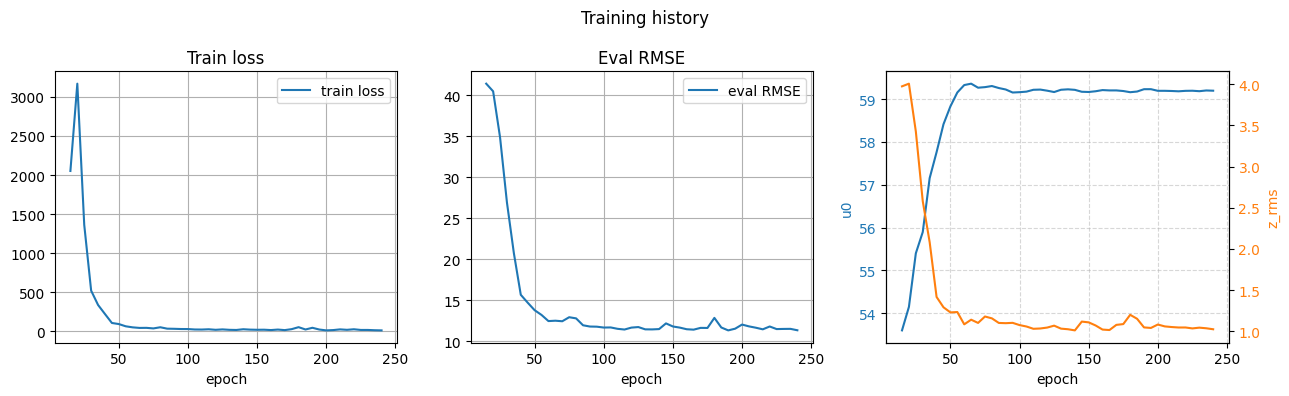

In [37]:
plot_history(his, start_loss=15, start_rmse=15, start_u0=15)

In [25]:
model, his=train_deep_bsde(lr=5*1e-1,B=256,d=100,hidden=64,epochs=400,N=20,driver_mode="awd")

[001] train_loss=13562054.000000  eval_rmse=4129931.2647  corr=0.0058  u0=50.4998  z_rms=392194.3125
[020] train_loss=1251.420410  eval_rmse=39.0169  corr=-0.0809  u0=54.1985  z_rms=3.7100
[040] train_loss=136.410431  eval_rmse=14.6375  corr=0.0453  u0=57.9268  z_rms=1.3853
[060] train_loss=45.835583  eval_rmse=11.7920  corr=0.0680  u0=58.7024  z_rms=1.0826
[080] train_loss=50.403580  eval_rmse=11.8827  corr=0.0492  u0=58.4212  z_rms=1.0712
[100] train_loss=26.464344  eval_rmse=11.5093  corr=0.0962  u0=58.4278  z_rms=1.0523
[120] train_loss=28.617088  eval_rmse=11.1411  corr=0.1117  u0=58.4059  z_rms=1.0328
[140] train_loss=22.576191  eval_rmse=11.3987  corr=0.0969  u0=58.3627  z_rms=1.0506
[160] train_loss=21.546190  eval_rmse=11.5676  corr=0.0912  u0=58.3561  z_rms=1.0632


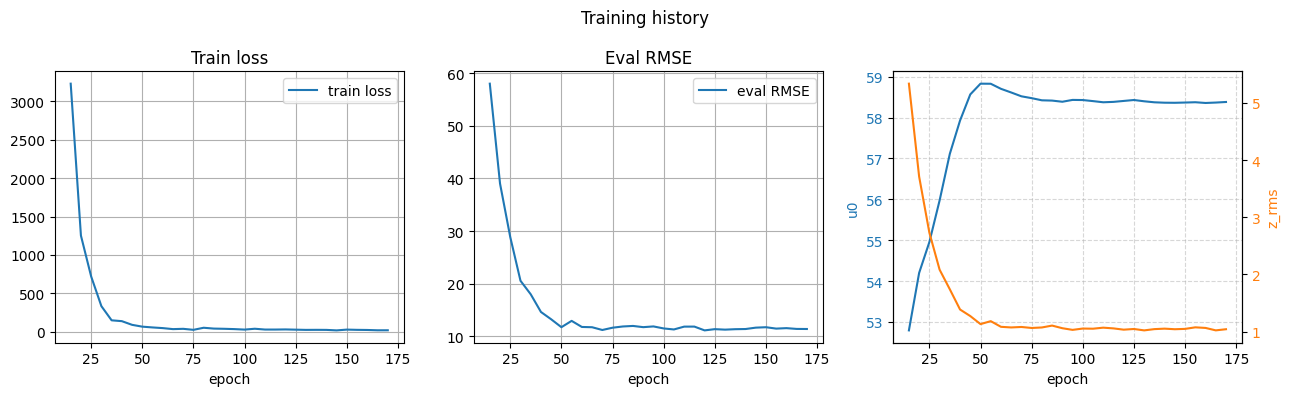

In [33]:
plot_history(his, start_loss=15, start_rmse=15, start_u0=15)

We get a pretty significant price difference. We can also see that the model converges rather well, although it could be improved by taking bigger batchsizes (not enough memory on my end)

### Hamilton-Jacobi-Bellman equation

In [15]:
class HJB:
    def __init__(self,lam, T):
        self.lam=lam
        self.T=T

    @staticmethod
    def sigma(t, x):

        return math.sqrt(2)*torch.eye(x.shape[-1], device=x.device, dtype=x.dtype)+torch.zeros_like(x).unsqueeze(-1)

    @staticmethod
    def mu( t: float, X: torch.tensor):
        return torch.zeros_like(X)

    @staticmethod
    def g(x):
        return torch.log((1+torch.sum(x**2,dim=-1))/2)


    def f(self,t,x,u,z):
        return -1/2 * (z**2).sum(-1, keepdim=True) * self.lam

    @staticmethod
    def df_du(t, x, u , z):
        return torch.zeros_like(u)

    def df_dgrad(self, t, x, u ,z):
        return -self.lam*z

In [19]:
@torch.no_grad()
def HJB_make_eval_set(hjb, B_eval, N, d, device, dtype, seed=999):
    gen = torch.Generator(device=device).manual_seed(seed)
    dW = torch.randn((B_eval, N, d), generator=gen, device=device, dtype=dtype) * math.sqrt(hjb.T / N)
    xi = torch.full((B_eval, d), 100.0, device=device, dtype=dtype)
    X = simulate_X(xi, dW, hjb.mu, hjb.sigma, hjb.T)
    return dW, X

def HJB_make_train_paths(hjb, B, N, d, device, dtype, seed=None, antithetic=False):
    gen = torch.Generator(device=device)
    if seed is not None:
        gen.manual_seed(seed)
    dW = torch.randn((B, N, d), generator=gen, device=device, dtype=dtype) * math.sqrt(hjb.T / N)
    if antithetic:
        dW = torch.cat([dW, -dW], dim=0)  # doubles batch
    xi = torch.full((dW.size(0), d), 100.0, device=device, dtype=dtype)
    X = simulate_X(xi, dW, hjb.mu, hjb.sigma, hjb.T)
    return dW, X

def train_HJB(d=10, N=40, B=4096, epochs=600, lam=1, T=1, resample=True,
              lr=3e-3, z_reg=1e-7, antithetic=False, hidden=64, device=None, dtype=torch.float32, seed=0,
              startpoint=None, early_stop=True, check_every=5, patience_checks=10, min_delta=1e-4):
    device = device or (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    torch.manual_seed(seed)

    hjb=HJB(lam, T)
    hjb.mu(1,torch.zeros(4))
    B_eval=B
    dW_eval, X_eval=HJB_make_eval_set(hjb, B_eval, N, d, device, dtype, seed=seed)

    dW, X = HJB_make_train_paths(hjb, B, N, d, device, dtype, seed=seed, antithetic=antithetic)
    t = get_time_scale(N, hjb.T).to(device=device, dtype=dtype)

    params = parameters(hjb.f, hjb.sigma, hjb.mu, dW, X, t, hjb.df_du, hjb.df_dgrad)

    model = Time_solver(params, hidden=hidden, init_theta_u0=startpoint).to(device)
    model.rec.trace = False
    opt=torch.optim.Adam(model.parameters(),lr=lr)
    #sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs, eta_min=1e-5)
    mse=nn.MSELoss()

    stopper = EarlyStopper(patience_checks=patience_checks, min_delta=min_delta) if early_stop else None
    history = init_history()

    for ep in range(1, epochs+1):
        model.train()
        opt.zero_grad(set_to_none=True)

        if resample:
            dW, X = HJB_make_train_paths(hjb, B, N, d, device, dtype, seed=None, antithetic=antithetic)

        with torch.no_grad():
            model.rec.params.delta_W.set_(dW)
            model.rec.params.X.set_(X)
            model.rec.params.B, model.rec.params.N, model.rec.params.d = dW.shape

        # Forward and loss
        uT = model(X, t)                                      # [B,1]
        gT = hjb.g(X[:, -1, :]).unsqueeze(-1)                  # [B,1]


        loss_term = mse(uT, gT)

        # z-regularization (very small)
        z_pen = 0.0
        if model.rec.last_z is not None and z_reg > 0:
            z_pen = (model.rec.last_z.square().mean()) * (hjb.T / N)  # average over time
        loss = loss_term + z_reg * z_pen

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        opt.step(); #sched.step()

        do_eval = (ep % check_every == 0) or (ep == 1)
        do_print = (ep % 20 == 0) or (ep == 1)
        if do_eval:
            model.eval()
            with torch.no_grad():
                model.rec.trace = True
                model.rec.params.delta_W.set_(dW_eval)
                model.rec.params.X.set_(X_eval)
                model.rec.params.B, model.rec.params.N, model.rec.params.d = dW_eval.shape

                uT_eval = model(X_eval, t)
                gT_eval = hjb.g(X_eval[:, -1, :]).unsqueeze(-1)

                mse_eval = mse(uT_eval, gT_eval).item()
                rmse_eval = math.sqrt(mse_eval)
                corr = torch.corrcoef(torch.stack([uT_eval.squeeze(), gT_eval.squeeze()], 0))[0,1].item()
                theta_u0 = float(model.rec.theta_u_0.detach().cpu())
                zn = float(model.rec.last_z.square().mean().sqrt().cpu()) if model.rec.last_z is not None else float('nan')

                # Log
                history["epoch"].append(ep)
                history["train_loss"].append(float(loss.item()))
                history["eval_rmse"].append(float(rmse_eval))
                history["corr"].append(float(corr))
                history["u0"].append(theta_u0)
                history["z_rms"].append(float(zn))

                if do_print:
                    print(f"[{ep:03d}] train_loss={loss.item():.6f}  eval_rmse={rmse_eval:.4f}  corr={corr:.4f}  "
                          f"u0={theta_u0:.4f}  z_rms={zn:.4f}")

                if early_stop and ep >= check_every:
                    if stopper.step(rmse_eval):
                        if do_print:
                            print(f"Early stopping at epoch {ep} (no improvement for {patience_checks} checks).")
                        break
                model.rec.trace = False
    return model, history

In [20]:
model, his = train_HJB(lr=1e-1,B=256,d=100,hidden=64,epochs=400,N=40,startpoint=10.)

[001] train_loss=785720704.000000  eval_rmse=42284460.0057  corr=0.8582  u0=9.9001  z_rms=919.6001
[020] train_loss=0.771303  eval_rmse=2.1138  corr=-0.1827  u0=10.5889  z_rms=0.2145
[040] train_loss=0.240096  eval_rmse=1.7888  corr=-0.2125  u0=11.1530  z_rms=0.1854
[060] train_loss=0.094123  eval_rmse=1.6592  corr=-0.2484  u0=11.5340  z_rms=0.1650
[080] train_loss=0.055177  eval_rmse=1.4994  corr=-0.2600  u0=11.8231  z_rms=0.1486
[100] train_loss=0.040608  eval_rmse=1.3312  corr=-0.2511  u0=12.0691  z_rms=0.1320
[120] train_loss=0.029341  eval_rmse=1.1610  corr=-0.2471  u0=12.3038  z_rms=0.1141
[140] train_loss=0.019840  eval_rmse=0.9733  corr=-0.2364  u0=12.5312  z_rms=0.0947
[160] train_loss=0.011968  eval_rmse=0.7637  corr=-0.2218  u0=12.7381  z_rms=0.0738
[180] train_loss=0.006006  eval_rmse=0.5418  corr=-0.2062  u0=12.9079  z_rms=0.0520
[200] train_loss=0.002283  eval_rmse=0.3323  corr=-0.1907  u0=13.0256  z_rms=0.0318
[220] train_loss=0.000603  eval_rmse=0.1688  corr=-0.1714  u0

In [21]:
def hjb_mc(x, t, T, lam, B=1000, N=40, d=100):
    hjb=HJB(lam, T)
    g=hjb.g
    dW=generate_delta_brownian(B, N, d, T)

    n=(T-t)*(N+1)
    if n==0:
        w=0
    else:
        dW=dW[:,:n,:]
        w=dW.sum(1)
    u = -(1.0/lam) * torch.log( torch.mean( torch.exp(-lam*g(x + math.sqrt(2)*w))))
    return u

In [22]:
d=100
lam=1
T=1
t=0
hjb=HJB(lam,T)
g=hjb.g
x=torch.ones(d)*100
print(hjb_mc(x, t, T, lam, d=d))

tensor(13.1225)


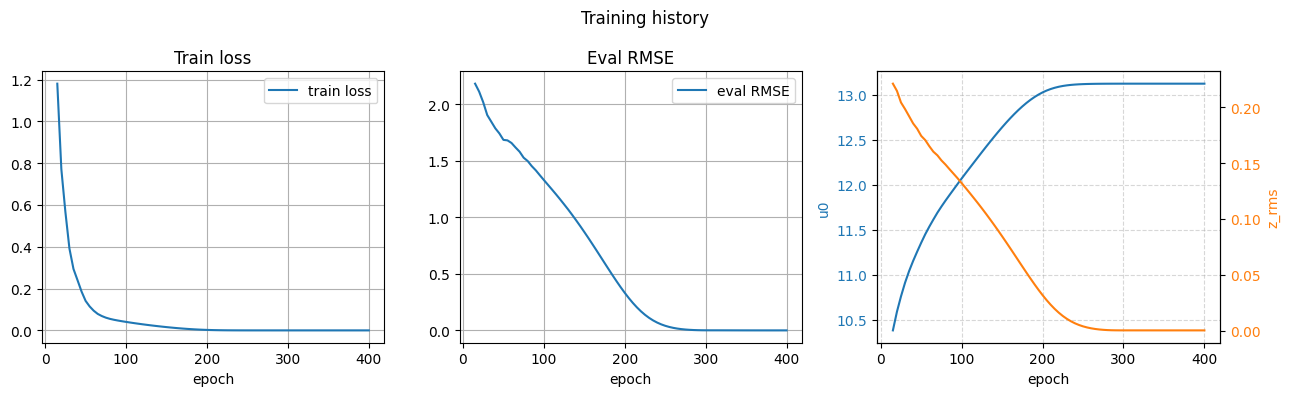

In [25]:
plot_history(his, start_loss=15, start_rmse=15, start_u0=15)

### Allen-Cahn Equation

In [26]:
class AllenCahn:
    def __init__(self, T=0.3):
        self.T = T

    # dynamics (heat operator): Δ => σ = sqrt(2) I, μ = 0
    def sigma(self, t, x):
        d = x.shape[-1]
        I = torch.eye(d, device=x.device, dtype=x.dtype)
        return math.sqrt(2.0) * I + torch.zeros_like(x).unsqueeze(-1)

    def mu(self, t, x):
        return torch.zeros_like(x)

    # driver f(u) = u - u^3
    def f(self, t, x, u, z):
        return u - u.pow(3)

    @staticmethod
    def df_du(t, x, u, z):
        return 1.0 - 3.0 * u.pow(2)

    @staticmethod
    def df_dgrad(t, x, u, z):
        return torch.zeros_like(z)

    # a common terminal condition (modifiable)
    # g(x) = (2 + 0.4/d * sum_i x_i)^(-1)
    def g(self, x, alpha=0.4):
        d = x.shape[-1]
        s = x.pow(2).sum(dim=-1, keepdim=False) / d
        return 1.0 / (2.0 + alpha * s)



In [78]:
@torch.no_grad()
def AC_make_eval_set(ac, B_eval, N, d, device, dtype, seed=999):
    gen = torch.Generator(device=device).manual_seed(seed)
    dW = torch.randn((B_eval, N, d), generator=gen, device=device, dtype=dtype) * math.sqrt(ac.T / N)
    xi = torch.zeros((B_eval, d), device=device, dtype=dtype)  # typical choice x0=0
    X  = simulate_X(xi, dW, ac.mu, ac.sigma, ac.T)
    return dW, X

def AC_make_train_paths(ac, B, N, d, device, dtype, seed=None, antithetic=False):
    gen = torch.Generator(device=device)
    if seed is not None:
        gen.manual_seed(seed)
    dW = torch.randn((B, N, d), generator=gen, device=device, dtype=dtype) * math.sqrt(ac.T / N)
    if antithetic:
        dW = torch.cat([dW, -dW], dim=0)
    xi = torch.zeros((dW.size(0), d), device=device, dtype=dtype)
    X  = simulate_X(xi, dW, ac.mu, ac.sigma, ac.T)
    return dW, X

def train_AllenCahn(
    d=100, N=60, B=4096, epochs=800, T=0.3,
    lr=3e-4, z_reg=0.0, antithetic=True, hidden=128, device=None, dtype=torch.float32,
    seed=0, resample=True, init_theta_u0=1.0,
    early_stop=True, check_every=5, patience_checks=12, min_delta=1e-4, use_tanh=False, z_scale=1.0, print_every=20,
):
    device = device or (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    torch.manual_seed(seed)

    ac = AllenCahn(T=T)
    B_eval = B
    dW_eval, X_eval = AC_make_eval_set(ac, B_eval, N, d, device, dtype, seed=seed)
    dW, X = AC_make_train_paths(ac, B, N, d, device, dtype, seed=seed, antithetic=antithetic)
    t = get_time_scale(N, ac.T).to(device=device, dtype=dtype)

    params = parameters(ac.f, ac.sigma, ac.mu, dW, X, t, ac.df_du, ac.df_dgrad)

    model = Time_solver(params, hidden=hidden,init_theta_u0=torch.tensor(init_theta_u0, dtype=dtype, device=device),
                        use_tanh=use_tanh, z_scale=z_scale).to(device)
    model.rec.trace = False

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs, eta_min=1e-5)
    mse = nn.MSELoss()

    stopper = EarlyStopper(patience_checks=patience_checks, min_delta=min_delta) if early_stop else None
    history = init_history()

    for ep in range(1, epochs+1):
        model.train()
        opt.zero_grad(set_to_none=True)

        if resample:
            dW, X = AC_make_train_paths(ac, B, N, d, device, dtype, seed=None, antithetic=antithetic)

        with torch.no_grad():
            model.rec.params.delta_W.set_(dW)
            model.rec.params.X.set_(X)
            model.rec.params.B, model.rec.params.N, model.rec.params.d = dW.shape

        uT = model(X, t)
        gT = ac.g(X[:, -1, :]).unsqueeze(-1)
        loss_term = mse(uT, gT)

        z_pen = 0.0
        if model.rec.last_z is not None and z_reg > 0:
            z_pen = (model.rec.last_z.square().mean()) * (ac.T / N)
        loss = loss_term + z_reg * z_pen

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        opt.step(); sched.step()

        do_eval = (ep % check_every == 0) or (ep == 1)
        do_print = (ep % print_every == 0) or (ep == 1)
        if do_eval:
            model.eval()
            with torch.no_grad():
                model.rec.trace = True
                model.rec.params.delta_W.set_(dW_eval)
                model.rec.params.X.set_(X_eval)
                model.rec.params.B, model.rec.params.N, model.rec.params.d = dW_eval.shape

                uT_eval = model(X_eval, t)
                gT_eval = ac.g(X_eval[:, -1, :]).unsqueeze(-1)

                mse_eval = mse(uT_eval, gT_eval).item()
                rmse_eval = math.sqrt(mse_eval)
                corr = torch.corrcoef(torch.stack([uT_eval.squeeze(), gT_eval.squeeze()], 0))[0,1].item()
                theta_u0 = float(model.rec.theta_u_0.detach().cpu())
                zn = float(model.rec.last_z.square().mean().sqrt().cpu()) if model.rec.last_z is not None else float('nan')

                history["epoch"].append(ep)
                history["train_loss"].append(float(loss.item()))
                history["eval_rmse"].append(float(rmse_eval))
                history["corr"].append(float(corr))
                history["u0"].append(theta_u0)
                history["z_rms"].append(float(zn))

                if do_print:
                    print(f"[{ep:03d}] train_loss={loss.item():.6f}  eval_rmse={rmse_eval:.4f}  corr={corr:.4f}  "
                          f"u0={theta_u0:.4f}  z_rms={zn:.4f}")

                if early_stop and ep >= check_every:
                    if stopper.step(rmse_eval):
                        if do_print:
                            print(f"Early stopping at epoch {ep} (no improvement for {patience_checks} checks).")
                        break
                model.rec.trace = False

    return model, history


In [84]:
model, his = train_AllenCahn(lr=5*1e-2,B=256,d=100,hidden=64,epochs=400,N=40, use_tanh=True, z_scale=0.3, print_every=5,
                             init_theta_u0=0.04, z_reg=1e-5)

[001] train_loss=0.175155  eval_rmse=0.3815  corr=0.0249  u0=0.0900  z_rms=0.0133
[005] train_loss=0.015369  eval_rmse=0.3198  corr=-0.0461  u0=0.2317  z_rms=0.0301
[010] train_loss=0.002577  eval_rmse=0.2946  corr=-0.0675  u0=0.2875  z_rms=0.0382
[015] train_loss=0.000998  eval_rmse=0.2802  corr=-0.0740  u0=0.3266  z_rms=0.0409
[020] train_loss=0.000517  eval_rmse=0.2716  corr=-0.0788  u0=0.3467  z_rms=0.0426
[025] train_loss=0.000245  eval_rmse=0.2669  corr=-0.0752  u0=0.3595  z_rms=0.0432
[030] train_loss=0.000150  eval_rmse=0.2643  corr=-0.0738  u0=0.3676  z_rms=0.0438
[035] train_loss=0.000091  eval_rmse=0.2626  corr=-0.0744  u0=0.3722  z_rms=0.0441
[040] train_loss=0.000048  eval_rmse=0.2617  corr=-0.0751  u0=0.3751  z_rms=0.0443
[045] train_loss=0.000031  eval_rmse=0.2609  corr=-0.0785  u0=0.3769  z_rms=0.0444
[050] train_loss=0.000017  eval_rmse=0.2608  corr=-0.0791  u0=0.3780  z_rms=0.0445
[055] train_loss=0.000011  eval_rmse=0.2605  corr=-0.0781  u0=0.3786  z_rms=0.0445
[060]